In [1]:
import jax
import jax.numpy as jnp
import jax.random as random
import jax.scipy as jsp
import optax
import matplotlib.pyplot as plt
from minigp.warpednn import *

In [2]:
def loss_f_fit(params, model: ICNN_Grad, X, y):
    """
    Suppose we want the scalar f_\theta(x) to fit some target y (like regression).
    We'll do MSE: mean((f(x) - y)^2).
    """
    pred = model.f_batch(X, params)  # shape (batch,)
    return jnp.mean((pred - y)**2)

def loss_grad_fit(params, model: ICNN_Grad, X, y_grad):
    """
    Suppose we want the gradient f'(x) to fit some target vector y_grad (shape (batch, input_dim)).
    We'll do MSE on each component: mean(||grad_f(x) - y_grad||^2).
    """
    pred_grad = model.grad_batch(X, params)  # (batch, input_dim)
    return jnp.mean((pred_grad - y_grad)**2)

In [3]:
def quad_1d(x):
    y = x[0]**2 + 1
    return jnp.array([y])

In [4]:
def quad_1d_grad(x):
    y = 2 * x[0]
    return jnp.array([y])

In [5]:
def generate_synthetic_data(
    func: Callable[[jnp.ndarray], jnp.ndarray],
    grad: Callable[[jnp.ndarray], jnp.ndarray],
    n_samples: int = 50,
    input_dim: int = 1,
    output_dim: int = 1,
    x_range: Tuple[float, float] = (-2.0, 2.0),
    seed: int = 0
) -> Tuple[jnp.ndarray, jnp.ndarray, jnp.ndarray]:
    key = random.PRNGKey(seed)
    X = random.uniform(
        key,
        shape=(n_samples, input_dim),
        minval=x_range[0],
        maxval=x_range[1]
    )

    X = jnp.linspace(x_range[0], x_range[1], n_samples).reshape(-1, 1)

    Y = jax.vmap(func)(X)
    Ygrad = jax.vmap(grad)(X)

    return X, Y, Ygrad

In [6]:
def plot_heatmaps(params, step):
    """
    Plot heatmaps for the `raw_W` and `raw_U` matrices of each layer using 'hot' colormap.
    """
    num_layers = len([key for key in params.keys() if key.startswith('raw_W')])
    num_layers -= 2

    fig, axes = plt.subplots(num_layers, 2, figsize=(10, 5 * num_layers))

    if num_layers == 1:
        axes = [axes]  # Ensure axes indexing works correctly for a single layer

    for i in range(1,num_layers + 1):
        W = params[f'raw_W{i+1}']
        U = params[f'raw_U{i+1}']

        # Plot heatmap for W
        ax1 = axes[i][0]
        im1 = ax1.imshow(W, cmap='hot', aspect='auto')
        ax1.set_title(f'raw_W{i+1} at step {step}')
        plt.colorbar(im1, ax=ax1)

        # Plot heatmap for U
        ax2 = axes[i][1]
        im2 = ax2.imshow(U, cmap='hot', aspect='auto')
        ax2.set_title(f'raw_U{i+1} at step {step}')
        plt.colorbar(im2, ax=ax2)

    plt.tight_layout()
    plt.show()

In [ ]:
def sanity_check_1d_convex_and_gradient(func, grad, lr = 0.05):
    x_vals = jnp.linspace(-2, 2, 50)
    f_true_vals = x_vals**2 + 1.0
    grad_true_vals = 2.0 * x_vals

    X_train = jnp.array(x_vals.reshape(-1,1))  # shape (50,1)
    Yf_train = jnp.array(f_true_vals)          # shape (50,)
    Ygrad_train = jnp.array(grad_true_vals) # shape (50,1)
    n_samples = 50

    print(Yf_train)
    # X_train, Yf_train, Ygrad_train = generate_synthetic_data(func, grad, n_samples=n_samples)
    print(Yf_train)


    
    key = random.PRNGKey(0)
    layer_dims = [1, 32, 32, 1]
    model = ICNN_Grad(layer_dims, key)

    optimizer = optax.adam(lr)
    opt_state = optimizer.init(model.params)
    def update_f(params, opt_state):
        loss_val, grads = jax.value_and_grad(loss_f_fit)(params, model, X_train, Yf_train)
        updates, opt_state = optimizer.update(grads, opt_state)
        new_params = optax.apply_updates(params, updates)
        return new_params, opt_state, loss_val

    for step in range(2000):
        model.params, opt_state, loss_val = update_f(model.params, opt_state)
        if step % 500 == 0:
            print(f"[f-fit] step={step}, loss={loss_val:.6f}")

    f_learned = model.f_batch(X_train, model.params)
    grad_learned = model.grad_batch(X_train, model.params)
    
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.plot(X_train, Yf_train, 'k--', label='True f(x)=x^2+1')
    plt.plot(X_train, jnp.array(f_learned), 'r-', label='Learned f')
    plt.title("Convex f(x) vs. Learned")
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(X_train, Ygrad_train, 'k--', label='True grad=2x')
    plt.plot(X_train, jnp.array(grad_learned).squeeze(), 'r-', label='Learned grad')
    plt.title("Gradient vs. Learned grad")
    plt.legend()
    plt.show()

def sanity_check_1d_grad_fit(func, grad, lr=0.05):

    x_vals = jnp.linspace(-2, 2, 50)
    f_true_vals = x_vals**2 + 1.0
    grad_true_vals = 2.0 * x_vals

    X_train = jnp.array(x_vals.reshape(-1,1))  # shape (50,1)
    Yf_train = jnp.array(f_true_vals)          # shape (50,)
    Ygrad_train = jnp.array(grad_true_vals.reshape(-1,1)) # shape (50,1)
    n_samples = 50

    n_samples = 50
    # X_train, Yf_train, Ygrad_train = generate_synthetic_data(func, grad, n_samples=n_samples)

    key = random.PRNGKey(42)
    layer_dims = [1, 32, 32, 1]
    model = ICNN_Grad(layer_dims, key)

    optimizer = optax.adam(lr)
    opt_state = optimizer.init(model.params)
    def update_grad(params, opt_state):
        loss_val, grads = jax.value_and_grad(loss_grad_fit)(params, model, X_train, Ygrad_train)
        updates, opt_state = optimizer.update(grads, opt_state)
        new_params = optax.apply_updates(params, updates)
        return new_params, opt_state, loss_val

    for step in range(2000):
        model.params, opt_state, loss_val = update_grad(model.params, opt_state)
        if step % 500 == 0:
            print(f"[grad-fit] step={step}, loss={loss_val:.6f}")
            # plot_heatmaps(model.params, step)

    f_learned = model.f_batch(X_train, model.params)
    grad_learned = model.grad_batch(X_train, model.params)

    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.plot(X_train, Yf_train, 'k--', label='True f(x)=x^2+1')
    plt.plot(X_train, jnp.array(f_learned), 'r-', label='Learned f (mod offset)')
    plt.title("f(x) shape after gradient-fit")
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(X_train, Ygrad_train, 'k--', label='True grad=2x')
    plt.plot(X_train, jnp.array(grad_learned).squeeze(), 'r-', label='Learned grad')
    plt.title("Gradient match")
    plt.legend()
    plt.show()


[5.        4.6801333 4.3735943 4.0803833 3.8004994 3.5339441 3.2807164
 3.0408163 2.8142443 2.6009998 2.4010825 2.2144938 2.0412328 1.8812995
 1.734694  1.6014161 1.4814662 1.3748438 1.2815493 1.2015827 1.1349438
 1.0816326 1.0416493 1.0149938 1.001666  1.001666  1.0149938 1.0416492
 1.0816326 1.1349437 1.2015827 1.2815493 1.3748437 1.4814659 1.601416
 1.7346938 1.8812994 2.0412328 2.2144938 2.4010825 2.6009994 2.8142438
 3.0408163 3.2807164 3.5339441 3.8004994 4.080383  4.373594  4.6801333
 5.       ]
[5.        4.6801333 4.3735943 4.0803833 3.8004994 3.5339441 3.2807164
 3.0408163 2.8142443 2.6009998 2.4010825 2.2144938 2.0412328 1.8812995
 1.734694  1.6014161 1.4814662 1.3748438 1.2815493 1.2015827 1.1349438
 1.0816326 1.0416493 1.0149938 1.001666  1.001666  1.0149938 1.0416492
 1.0816326 1.1349437 1.2015827 1.2815493 1.3748437 1.4814659 1.601416
 1.7346938 1.8812994 2.0412328 2.2144938 2.4010825 2.6009994 2.8142438
 3.0408163 3.2807164 3.5339441 3.8004994 4.080383  4.373594  4.6801

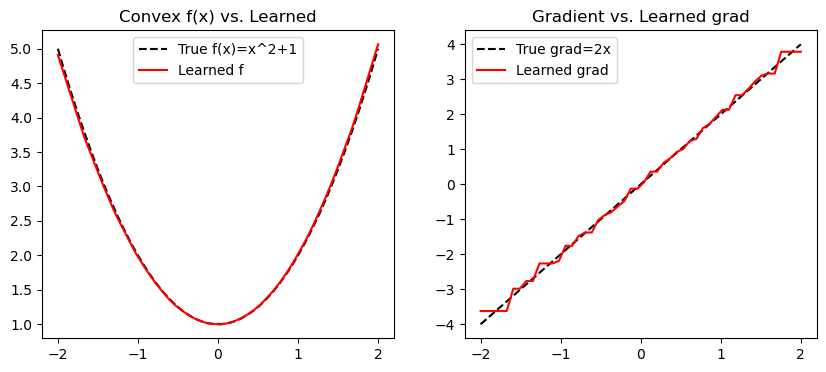

In [8]:
sanity_check_1d_convex_and_gradient(quad_1d, quad_1d_grad, lr=0.05)

[grad-fit] step=0, loss=5.554938
[grad-fit] step=500, loss=5.551015
[grad-fit] step=1000, loss=5.551015
[grad-fit] step=1500, loss=5.551019


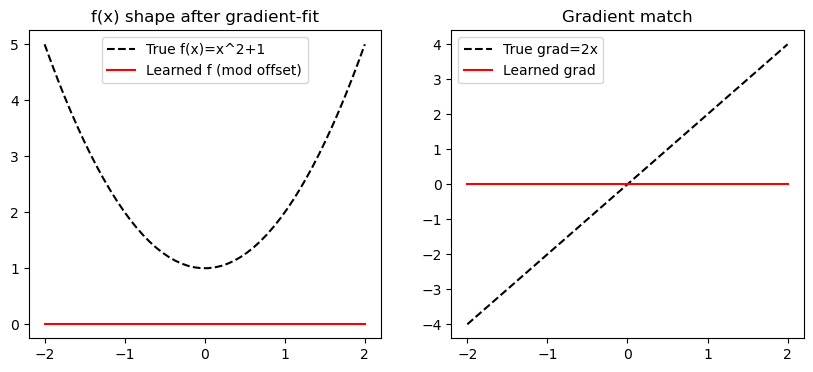

In [9]:
sanity_check_1d_grad_fit(quad_1d, quad_1d_grad, lr=0.05)